In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic, NMF, BaselineOnly
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from collections import defaultdict

# 전역 변수로 상태 관리
data = None
trainset = None
testset = None
algorithms = {}
results = {}


# 데이터 로드, 전처리
def load_data(ratings_file):
    global data, trainset, testset
    
    # ratings.dat 파일 형식: UserID::MovieID::Rating::Timestamp
    ratings_df = pd.read_csv(
        ratings_file, 
        sep='::', 
        names=['user_id', 'movie_id', 'rating', 'timestamp'],
        engine='python'
    )
    
    print(f"데이터 로드 완료: {len(ratings_df):,}개의 평점")
    print(f"사용자 수: {ratings_df['user_id'].nunique():,}명")
    print(f"영화 수: {ratings_df['movie_id'].nunique():,}개")
    print(f"평점 분포:\n{ratings_df['rating'].value_counts().sort_index()}")
        
    # Surprise 라이브러리용 데이터 준비
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
        
    # 80:20 비율로 데이터 분할
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
        
    return ratings_df


# 알고리즘 초기화
def initialize_algorithms():
    """알고리즘 초기화"""
    global algorithms
    
    algorithms = {
        'SVD': SVD(n_factors=100, n_epochs=20, random_state=42),
        'KNNBasic': KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': True}),
        'NMF': NMF(n_factors=50, n_epochs=50, random_state=42),
        'BaselineOnly': BaselineOnly()
    }
        
    print(f"초기화된 알고리즘: {list(algorithms.keys())}")


# 5-폴드 교차 검증, 알고리즘 평가
def cross_validation_evaluation():
    global results
    
    cv_results = {}
        
    for name, algorithm in algorithms.items():
        print(f"  - {name} 평가 중...")
        cv_result = cross_validate(
            algorithm, 
            data, 
            measures=['RMSE', 'MAE'], 
            cv=5, 
            verbose=False
        )
            
        cv_results[name] = {
            'RMSE': {
                'mean': cv_result['test_rmse'].mean(),
                'std': cv_result['test_rmse'].std()
            },
            'MAE': {
                'mean': cv_result['test_mae'].mean(),
                'std': cv_result['test_mae'].std()
            }
        }
        
    results['cross_validation'] = cv_results
    return cv_results


# top10 추천 목록 생성
def get_top_n_recommendations(predictions, n=10, threshold=4.0):
    # 각 사용자별로 예측된 평점을 정리
    top_n = defaultdict(list)
        
    for uid, iid, true_r, est, _ in predictions:
        if est >= threshold:
            top_n[uid].append((iid, est))
        
    # 각 사용자별로 예측 평점 기준 상위 N개 추출
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n


# Precision@K와 Recall@K 계산
def calculate_precision_recall(predictions, threshold=4.0, k=10):
    # 실제 선호도가 높은 아이템 (평점 4.0 이상)
    user_relevant_items = defaultdict(set)
        
    for uid, iid, true_r, est, _ in predictions:
        if true_r >= threshold:
            user_relevant_items[uid].add(iid)
        
    # Top-K 추천 목록
    top_k_recs = get_top_n_recommendations(predictions, n=k, threshold=threshold)
        
    precisions = []
    recalls = []
        
    for uid in user_relevant_items:
        if uid in top_k_recs:
            recommended_items = set([iid for iid, _ in top_k_recs[uid]])
            relevant_items = user_relevant_items[uid]
                
            if len(recommended_items) > 0:
                precision = len(recommended_items & relevant_items) / len(recommended_items)
                precisions.append(precision)
                
            if len(relevant_items) > 0:
                recall = len(recommended_items & relevant_items) / len(relevant_items)
                recalls.append(recall)
        
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
        
    return avg_precision, avg_recall


# top10 추천 평가
def evaluate_topn_recommendations():
    global results
    
    topn_results = {}
        
    for name, algorithm in algorithms.items():
        print(f"  - {name} Top-10 추천 평가 중...")
            
        # 알고리즘 학습
        algorithm.fit(trainset)
            
        # 테스트 세트 예측
        predictions = algorithm.test(testset)
            
        # Precision@10, Recall@10 계산
        precision, recall = calculate_precision_recall(predictions, threshold=4.0, k=10)
            
        topn_results[name] = {
            'Precision@10': precision,
            'Recall@10': recall
        }
        
    results['topn_evaluation'] = topn_results
    return topn_results

In [3]:
# 시각화
def visualize_results():
    # 서브플롯 설정
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
    # RMSE
    algorithm_names = list(results['cross_validation'].keys())
    rmse_means = [results['cross_validation'][alg]['RMSE']['mean'] for alg in algorithm_names]
    rmse_stds = [results['cross_validation'][alg]['RMSE']['std'] for alg in algorithm_names]
        
    bars1 = ax1.bar(algorithm_names, rmse_means, yerr=rmse_stds, capsize=5, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax1.set_title('Algorithm Comparison - RMSE', fontsize=14, fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.set_ylim(0, max(rmse_means) * 1.2)
        
    for bar, mean in zip(bars1, rmse_means):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
        
    # MAE 
    mae_means = [results['cross_validation'][alg]['MAE']['mean'] for alg in algorithm_names]
    mae_stds = [results['cross_validation'][alg]['MAE']['std'] for alg in algorithm_names]
        
    bars2 = ax2.bar(algorithm_names, mae_means, yerr=mae_stds, capsize=5,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax2.set_title('Algorithm Comparison - MAE', fontsize=14, fontweight='bold')
    ax2.set_ylabel('MAE')
    ax2.set_ylim(0, max(mae_means) * 1.2)
        
    for bar, mean in zip(bars2, mae_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    # Precision@10
    precision_values = [results['topn_evaluation'][alg]['Precision@10'] for alg in algorithm_names]
        
    bars3 = ax3.bar(algorithm_names, precision_values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax3.set_title('Top-10 Recommendation - Precision@10', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Precision@10')
    ax3.set_ylim(0, max(precision_values) * 1.2 if max(precision_values) > 0 else 1)
        
    for bar, precision in zip(bars3, precision_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{precision:.3f}', ha='center', va='bottom', fontweight='bold')
        
    # Recall@10 
    recall_values = [results['topn_evaluation'][alg]['Recall@10'] for alg in algorithm_names]
        
    bars4 = ax4.bar(algorithm_names, recall_values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax4.set_title('Top-10 Recommendation - Recall@10', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Recall@10')
    ax4.set_ylim(0, max(recall_values) * 1.2 if max(recall_values) > 0 else 1)
        
    for bar, recall in zip(bars4, recall_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{recall:.3f}', ha='center', va='bottom', fontweight='bold')
        
    plt.tight_layout()
    plt.show()

In [5]:
# 상세한 결과 출력
def print_detailed_results():
    print("\n" + "="*80)
    print("                    영화 추천 시스템 성능 분석 결과")
    print("="*80)
    
    # 교차 검증 결과
    print("\n1. 5-폴드 교차 검증 결과:")
    print("-" * 60)
    print(f"{'Algorithm':<15} {'RMSE':<15} {'MAE':<15}")
    print("-" * 60)
    
    for alg_name in results['cross_validation']:
        rmse = results['cross_validation'][alg_name]['RMSE']['mean']
        mae = results['cross_validation'][alg_name]['MAE']['mean']
        print(f"{alg_name:<15} {rmse:<15.4f} {mae:<15.4f}")
    
    # Top-N 추천 결과
    print("\n2. Top-10 추천 성능:")
    print("-" * 60)
    print(f"{'Algorithm':<15} {'Precision@10':<15} {'Recall@10':<15}")
    print("-" * 60)
    
    for alg_name in results['topn_evaluation']:
        precision = results['topn_evaluation'][alg_name]['Precision@10']
        recall = results['topn_evaluation'][alg_name]['Recall@10']
        print(f"{alg_name:<15} {precision:<15.4f} {recall:<15.4f}")


# 최적 알고리즘 추천
def recommend_best_algorithm():
    print("\n3. 최적 알고리즘 추천:")
    print("-" * 60)
    
    # RMSE 기준 최적 알고리즘
    best_rmse_alg = min(results['cross_validation'].items(), 
                       key=lambda x: x[1]['RMSE']['mean'])
    print(f"RMSE 기준 최적: {best_rmse_alg[0]} (RMSE: {best_rmse_alg[1]['RMSE']['mean']:.4f})")
    
    # MAE 기준 최적 알고리즘
    best_mae_alg = min(results['cross_validation'].items(), 
                      key=lambda x: x[1]['MAE']['mean'])
    print(f"MAE 기준 최적: {best_mae_alg[0]} (MAE: {best_mae_alg[1]['MAE']['mean']:.4f})")
    
    # Precision@10 기준 최적 알고리즘
    best_precision_alg = max(results['topn_evaluation'].items(), 
                            key=lambda x: x[1]['Precision@10'])
    print(f"Precision@10 기준 최적: {best_precision_alg[0]} (Precision: {best_precision_alg[1]['Precision@10']:.4f})")
    
    # Recall@10 기준 최적 알고리즘
    best_recall_alg = max(results['topn_evaluation'].items(), 
                         key=lambda x: x[1]['Recall@10'])
    print(f"Recall@10 기준 최적: {best_recall_alg[0]} (Recall: {best_recall_alg[1]['Recall@10']:.4f})")

영화 추천 시스템 성능 분석을 시작합니다...

1. 데이터 로드 중...
데이터 로드 완료: 1,000,209개의 평점
사용자 수: 6,040명
영화 수: 3,706개
평점 분포:
rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64

2. 알고리즘 초기화 중...
초기화된 알고리즘: ['SVD', 'KNNBasic', 'NMF', 'BaselineOnly']

3. 교차 검증 평가 중...
  - SVD 평가 중...
  - KNNBasic 평가 중...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  - NMF 평가 중...
  - BaselineOnly 평가 중...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...

4. Top-N 추천 평가 중...
  - SVD Top-10 추천 평가 중...
  - KNNBasic Top-10 추천 평가 중...
Computing the cosine sim

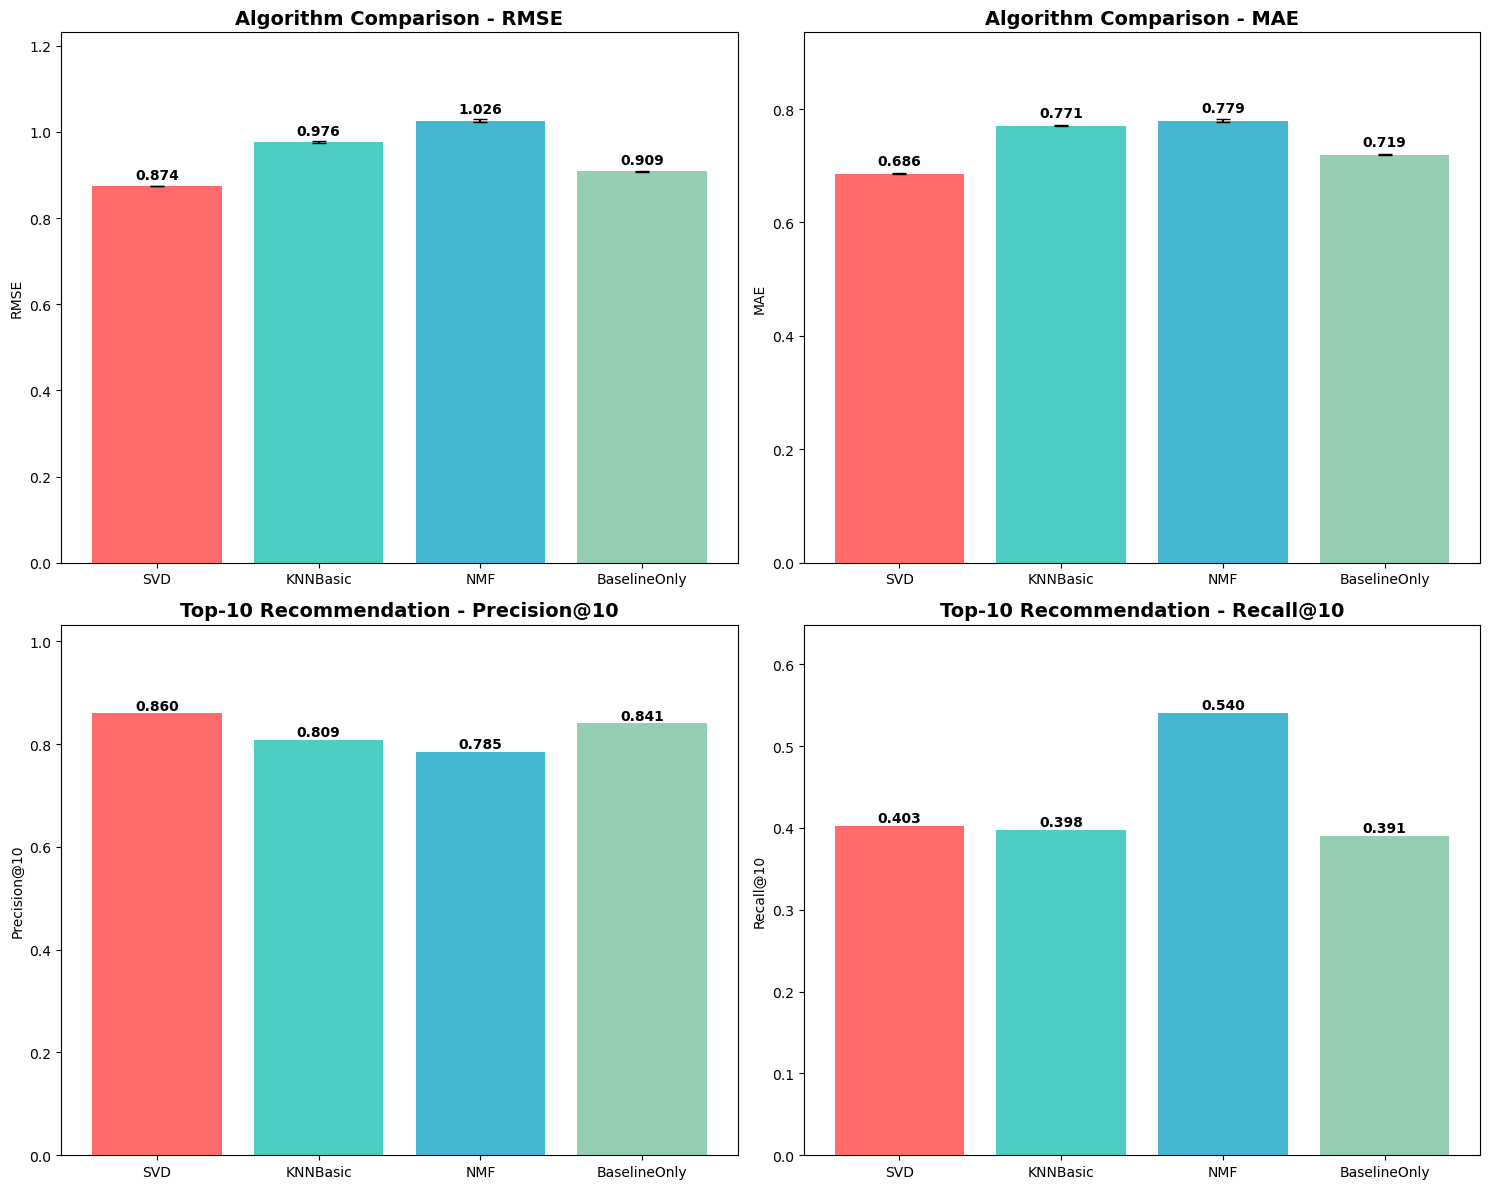

In [7]:
# 전체 실행
def run_complete_analysis(ratings_file):
    
    # 1. 데이터 로드
    print("\n1. 데이터 로드 중...")
    ratings_df = load_data(ratings_file)
    
    # 2. 알고리즘 초기화
    print("\n2. 알고리즘 초기화 중...")
    initialize_algorithms()
    
    # 3. 교차 검증 평가
    print("\n3. 교차 검증 평가 중...")
    cv_results = cross_validation_evaluation()
    
    # 4. Top-N 추천 평가
    print("\n4. Top-N 추천 평가 중...")
    topn_results = evaluate_topn_recommendations()
    
    # 5. 결과 출력
    print_detailed_results()
    
    # 6. 최적 알고리즘 추천
    recommend_best_algorithm()
    
    # 7. 시각화
    print("\n5. 결과 시각화 중...")
    visualize_results()
    
    return results

# 실행
results = run_complete_analysis('ratings.dat')